# No-Show Project: Investigate a Dataset 
## Table of Contents

<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction


In [1]:
%matplotlib inline
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns

<a id='wrangling'></a>
## Data Wrangling


### General Properties

In [2]:
#load Data file
df = pd.read_csv('noshowappointments-kagglev2-may-2016.csv')

# get brief look to File 
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,2.987250e+13,5642903,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No


In [3]:
# look in more details Like (Columns Name ,columns Number , Rows Number , missing records , Data Types )
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
PatientId         110527 non-null float64
AppointmentID     110527 non-null int64
Gender            110527 non-null object
ScheduledDay      110527 non-null object
AppointmentDay    110527 non-null object
Age               110527 non-null int64
Neighbourhood     110527 non-null object
Scholarship       110527 non-null int64
Hipertension      110527 non-null int64
Diabetes          110527 non-null int64
Alcoholism        110527 non-null int64
Handcap           110527 non-null int64
SMS_received      110527 non-null int64
No-show           110527 non-null object
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [4]:
#make sure there isn't missing records 
df.isnull().sum() 

PatientId         0
AppointmentID     0
Gender            0
ScheduledDay      0
AppointmentDay    0
Age               0
Neighbourhood     0
Scholarship       0
Hipertension      0
Diabetes          0
Alcoholism        0
Handcap           0
SMS_received      0
No-show           0
dtype: int64

In [5]:
# get some quick statistics 
df.describe()

,PatientId,AppointmentID,Age,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received
count,1.105270e+05,1.105270e+05,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000,110527.000000
mean,1.474963e+14,5.675305e+06,37.088874,0.098266,0.197246,0.071865,0.030400,0.022248,0.321026
std,2.560949e+14,7.129575e+04,23.110205,0.297675,0.397921,0.258265,0.171686,0.161543,0.466873
min,3.921784e+04,5.030230e+06,-1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,4.172614e+12,5.640286e+06,18.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,3.173184e+13,5.680573e+06,37.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,9.439172e+13,5.725524e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
max,9.999816e+14,5.790484e+06,115.000000,1.000000,1.000000,1.000000,1.000000,4.000000,1.000000


In [6]:
#column number of unique value
df.nunique()

PatientId          62299
AppointmentID     110527
Gender                 2
ScheduledDay      103549
AppointmentDay        27
Age                  104
Neighbourhood         81
Scholarship            2
Hipertension           2
Diabetes               2
Alcoholism             2
Handcap                5
SMS_received           2
No-show                2
dtype: int64

In [7]:
# Dublicated rows check
sum(df.duplicated())

0

In [8]:
# check for all columns to exetract any strange values 
df['Age'].unique()

# (-1) no age in negative
#Remove it in Cleaning Stage

array([ 62,  56,   8,  76,  23,  39,  21,  19,  30,  29,  22,  28,  54,
        15,  50,  40,  46,   4,  13,  65,  45,  51,  32,  12,  61,  38,
        79,  18,  63,  64,  85,  59,  55,  71,  49,  78,  31,  58,  27,
         6,   2,  11,   7,   0,   3,   1,  69,  68,  60,  67,  36,  10,
        35,  20,  26,  34,  33,  16,  42,   5,  47,  17,  41,  44,  37,
        24,  66,  77,  81,  70,  53,  75,  73,  52,  74,  43,  89,  57,
        14,   9,  48,  83,  72,  25,  80,  87,  88,  84,  82,  90,  94,
        86,  91,  98,  92,  96,  93,  95,  97, 102, 115, 100,  99,  -1])

In [9]:
#get Waiting days 
df['ScheduledDay']= pd.to_datetime(df['ScheduledDay']).dt.strftime('%Y-%m-%d')
df['AppointmentDay']= pd.to_datetime(df['AppointmentDay']).dt.strftime('%Y-%m-%d')

df['days_To_appointment']=(pd.to_datetime(df['AppointmentDay']) - pd.to_datetime(df['ScheduledDay'])).dt.days
df.head(1)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,days_To_appointment
0,2.987250e+13,5642903,F,2016-04-29,2016-04-29,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0


In [10]:
#some days in negative(invalid data)
df['days_To_appointment'].unique()

array([  0,   2,   3,   1,   4,   9,  29,  10,  23,  11,  18,  17,  14,
        28,  24,  21,  15,  16,  22,  43,  30,  31,  42,  32,  56,  45,
        46,  39,  37,  38,  44,  50,  60,  52,  53,  65,  67,  91,  66,
        84,  78,  87, 115, 109,  63,  70,  72,  57,  58,  51,  59,  41,
        49,  73,  64,  20,  33,  34,   6,  35,  36,  12,  13,  40,  47,
         8,   5,   7,  25,  26,  48,  27,  19,  61,  55,  62, 176,  54,
        77,  69,  83,  76,  89,  81, 103,  79,  68,  75,  85, 112,  -1,
        80,  86,  98,  94, 142, 155, 162, 169, 104, 133, 125,  96,  88,
        90, 151, 126, 127, 111, 119,  74,  71,  82, 108, 110, 102, 122,
       101, 105,  92,  97,  93, 107,  95,  -6, 139, 132, 179, 117, 146, 123])

### Data Cleaning 
After discussing the structure of the data and any problems that need to be
cleaned, perform those cleaning steps in the second part of this section.


In [11]:
#drop Age less than 0
df = df[df['Age'] >= 0]

In [12]:
#drop days_To_appointment less than 0
df = df[df['days_To_appointment'] >= 0]

In [13]:
#drop PatientId ,AppointmentID ,ScheduledDay, AppointmentDay
df.drop(['PatientId','AppointmentID','ScheduledDay','AppointmentDay'], axis=1, inplace = True)

df.head(1)

,Gender,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,days_To_appointment
0,F,62,JARDIM DA PENHA,0,1,0,0,0,0,No,0


<a id='eda'></a>
## Exploratory Data Analysis


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f180ccf07f0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x7f180f0d2128>]], dtype=object)

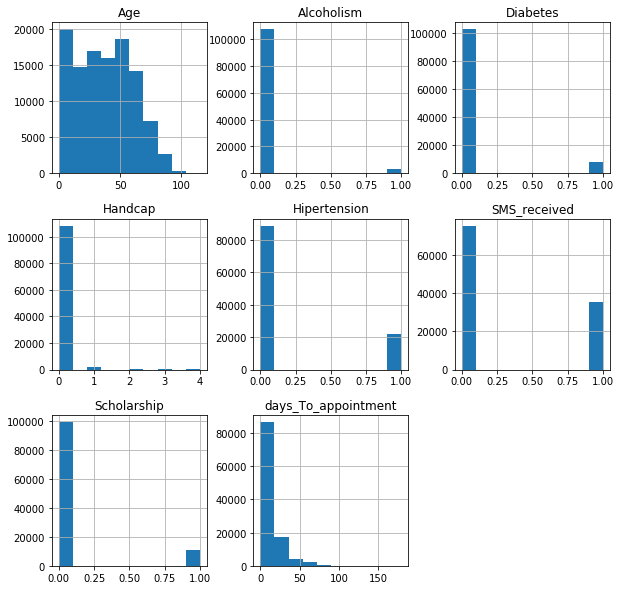

In [14]:
#quick histogram data 
df.hist(figsize=(10,10))

- Scholarship, Hipertension, Diabetes, Alcoholism is digital value
- age right skewed

In [21]:
def Noshow_Relations(columnName):
    colors = ['m', 'b']
    total =df.groupby([columnName]).count()['Age'] 
    G_group = df.groupby(['No-show',columnName])[columnName].count() / total;
    G_group.plot.bar(color = colors ,figsize= (10,7));
    plt.title('porportion of no shows based on '+ columnName)
    plt.xlabel('no-shows / '+ columnName)
    plt.ylabel('Percent of total')

Text(0.5,1,'No-Show percentage')

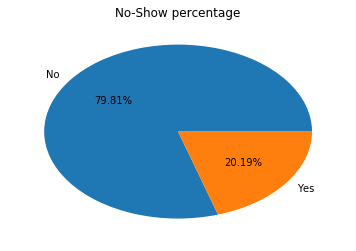

In [15]:
#Percenatge of No-show patient
NoShow = df['No-show'].value_counts()
plt.pie(NoShow,labels= ['No','Yes'],  autopct='%1.2f%%')

plt.title("No-Show percentage")


# Question 1 (Is no-show patient affected by SMS?By how much? )
Use this, and more code cells, to explore your data. Don't forget to add
Markdown cells to document your observations and findings.

Text(0.5,1,'SMS_received percentage')

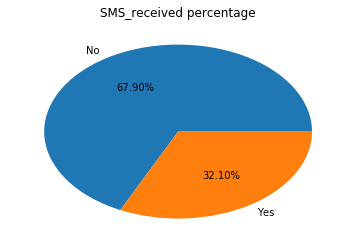

In [16]:
#percentage of SMS-receive
SMS_received = df['SMS_received'].value_counts()
plt.pie(SMS_received, labels= ['No','Yes'],  autopct='%1.2f%%')

plt.title("SMS_received percentage")

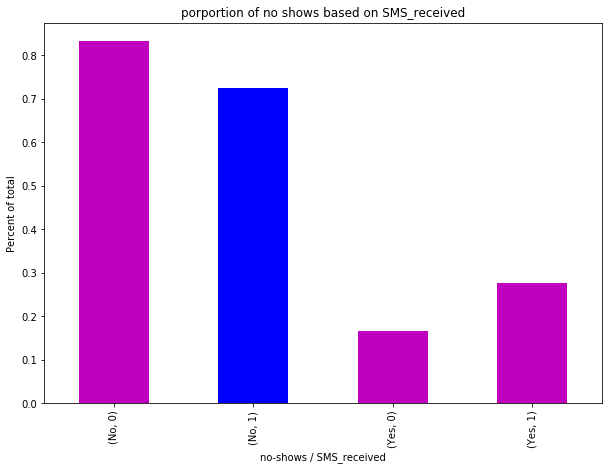

In [24]:
Noshow_Relations('SMS_received')

### Question 2  (Is No-show affected by Scholarship  )

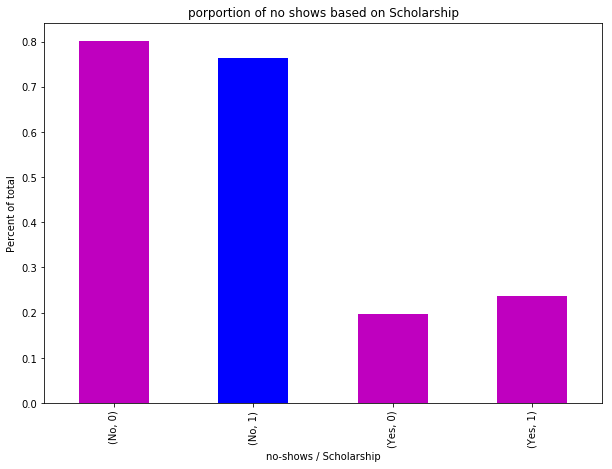

In [27]:
Noshow_Relations('Scholarship')

# Question 3 (Is No-show affected by Diabetes )

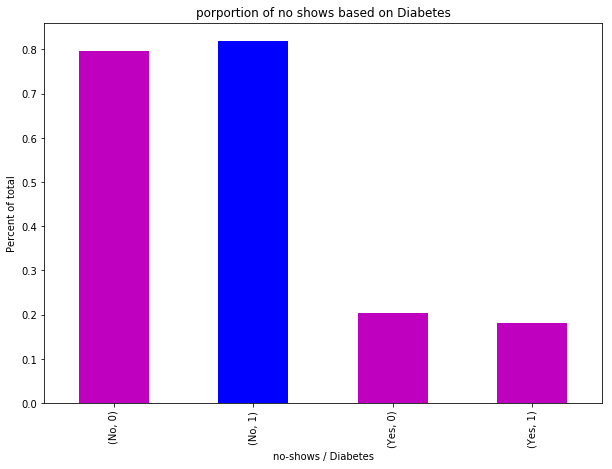

In [28]:
Noshow_Relations('Diabetes')

# Question 3 (Is No-show affected by Gender )

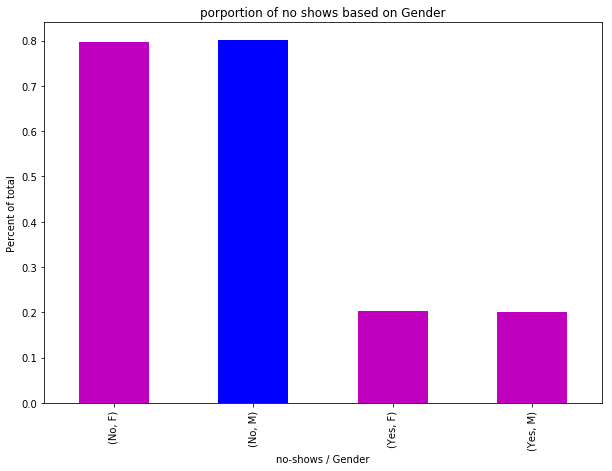

In [29]:
Noshow_Relations('Gender')

<a id='conclusions'></a>
## Conclusions

- No-show decrease by increase SMS.(major affect)
- No-show decrease by increase scholership
- No-show increase by decraese Diabetes (small affect)
- No-show not affect by gender 


## Submitting your Project 

> Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [20]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0